<a href="https://colab.research.google.com/github/fuyan2/ML_research/blob/master/gan_vs_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instructions for updating:
Colocations handled automatically by placer.


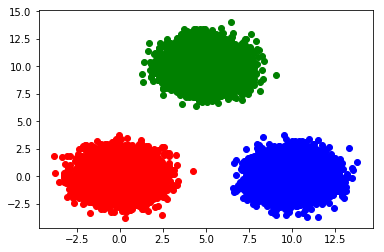

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
import math
inf = math.inf

tf.reset_default_graph()
tf.set_random_seed(1)

# Training Params
num_steps = 100000
learning_rate = 0.00002
x_dim = 2
noise_dim = 20
NUM_LABEL = 3
GAN_CLASS_COE = 10
gan_batch_size = 100*NUM_LABEL
num_data = 10000
INV_HIDDEN = 100
beta = 0.5 #1
lemda = 0.0001
 

# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.), dtype=tf.float32)
 
# Linear Regression 
class Generator(object):
  # G Parameters
  def __init__(self, noise_dim, NUM_LABEL):
    self.linear_w1 = tf.Variable(glorot_init([noise_dim+NUM_LABEL, 100]),name='glw1')
    self.linear_b1 = tf.Variable(tf.zeros([100]),name='glb1')
    self.linear_w2 = tf.Variable(glorot_init([100, 50]),name='glw2')
    self.linear_b2 = tf.Variable(tf.zeros([50]),name='glb2')
    self.linear_w3 = tf.Variable(glorot_init([50, x_dim]),name='glw3')
    self.linear_b3 = tf.Variable(tf.zeros([x_dim]),name='glb3')
    
    self.training = True

 # Build G Graph
  def __call__(self, z,y):
    z_y = tf.concat((z,y),1)
    linear_z1 = tf.nn.leaky_relu(tf.matmul(z_y,self.linear_w1) + self.linear_b1)
    linear_z2 = tf.nn.leaky_relu(tf.matmul(linear_z1,self.linear_w2) + self.linear_b2)
    out_layer = tf.matmul(linear_z2,self.linear_w3)+self.linear_b3
    return out_layer

# Logistic Regression
class Disciminator(object):
  # D Parameters
  def __init__(self):
    self.linear_w1 = tf.Variable(glorot_init([x_dim + NUM_LABEL, 100]))
    self.linear_b1 = tf.Variable(tf.zeros([100]))
    self.linear_w2 = tf.Variable(glorot_init([100, 1]))
    self.linear_b2 = tf.Variable(tf.zeros([1]))

    self.training = True

  # Build D Graph
  def __call__(self, x, y):
    x_y = tf.concat((x,y),1)
    linear1 = tf.nn.relu(tf.matmul(x_y, self.linear_w1) + self.linear_b1)
    out = tf.matmul(linear1, self.linear_w2) + self.linear_b2
    out = tf.sigmoid(out)
    return out

class AttackGenerator(object):
  # G Parameters
  def __init__(self, noise_dim, NUM_LABEL):
    self.linear_w1 = tf.Variable(glorot_init([noise_dim+NUM_LABEL, 100]),name='glw1')
    self.linear_b1 = tf.Variable(tf.zeros([100]),name='glb1')
    self.linear_w2 = tf.Variable(glorot_init([100, 50]),name='glw2')
    self.linear_b2 = tf.Variable(tf.zeros([50]),name='glb2')
    self.linear_w3 = tf.Variable(glorot_init([50, x_dim]),name='glw3')
    self.linear_b3 = tf.Variable(tf.zeros([x_dim]),name='glb3')
    
    self.training = True

 # Build G Graph
  def __call__(self, z,y):
    z_y = tf.concat((z,y),1)
    linear_z1 = tf.nn.leaky_relu(tf.matmul(z_y,self.linear_w1) + self.linear_b1)
    linear_z2 = tf.nn.leaky_relu(tf.matmul(linear_z1,self.linear_w2) + self.linear_b2)
    out_layer = tf.matmul(linear_z2,self.linear_w3)+self.linear_b3
    return out_layer

# Logistic Regression
class AttackDisciminator(object):
  # D Parameters
  def __init__(self):
    self.linear_w1 = tf.Variable(glorot_init([x_dim + NUM_LABEL, 100]))
    self.linear_b1 = tf.Variable(tf.zeros([100]))
    self.linear_w2 = tf.Variable(glorot_init([100, 1]))
    self.linear_b2 = tf.Variable(tf.zeros([1]))

    self.training = True

  # Build D Graph
  def __call__(self, x, y):
    x_y = tf.concat((x,y),1)
    linear1 = tf.nn.relu(tf.matmul(x_y, self.linear_w1) + self.linear_b1)
    out = tf.matmul(linear1, self.linear_w2) + self.linear_b2
    out = tf.sigmoid(out)
    return out
  
def plot_gan_image(name, epoch, sess):
  # Generate images from noise, using the generator network.
  fig, ax = plt.subplots()
  for i in range(NUM_LABEL):   
    # Desired label
    d_label = np.zeros([gan_batch_size, NUM_LABEL])
    d_label[:, i] = 1
    # Noise input.
    z = np.random.uniform(-1., 1., size=[gan_batch_size, noise_dim])
    g = sess.run([gen_sample], feed_dict={gen_input: z, train_y: d_label})
    g = np.reshape(g, [gan_batch_size,2])
    if i == 0:
      ax.scatter(g[:,0], g[:,1], c='r')
    elif i == 1:
      ax.scatter(g[:,0], g[:,1], c='b')
    elif i == 2:
      ax.scatter(g[:,0], g[:,1], c='g')
      
  plt.savefig(name+epoch)

def plot_attack_gan_image(name, epoch, sess):
  # Generate images from noise, using the generator network.
  fig, ax = plt.subplots()
  for i in range(NUM_LABEL):   
    # Desired label
    d_label = np.zeros([gan_batch_size, NUM_LABEL])
    d_label[:, i] = 1
    # Noise input.
    z = np.random.uniform(-1., 1., size=[gan_batch_size, noise_dim])
    g = sess.run([mi_x], feed_dict={attack_gen_input: z, desired_label: d_label})
    g = np.reshape(g, [gan_batch_size,2])
    if i == 0:
      ax.scatter(g[:,0], g[:,1], c='r')
    elif i == 1:
      ax.scatter(g[:,0], g[:,1], c='b')
    elif i == 2:
      ax.scatter(g[:,0], g[:,1], c='g')
      
  plt.savefig(name+epoch)
###################### Build Dataset #############################
features = tf.placeholder(tf.float32, shape=[None, x_dim])
labels = tf.placeholder(tf.float32, shape=[None, NUM_LABEL])
batch_size = tf.placeholder(tf.int64)
sample_size = tf.placeholder(tf.int64)
dataset = tf.data.Dataset.from_tensor_slices((features, labels))
dataset = dataset.shuffle(sample_size, reshuffle_each_iteration=True)
dataset = dataset.batch(batch_size, drop_remainder=True).repeat()
iterator = dataset.make_initializable_iterator()
next_batch = iterator.get_next()

mu1 = [0., 0.]
sigma1 = [[1., 0.], [0., 1.]]
mu2 = [10., 0.]
sigma2 = [[1., 0.], [0., 1.]]
mu3 = [5., 10.]
x_1 = np.random.multivariate_normal(mu1, sigma1, num_data)
x_2 = np.random.multivariate_normal(mu2, sigma1, num_data)
x_3 = np.random.multivariate_normal(mu3, sigma1, num_data)

plt.scatter(x_1[:,0], x_1[:,1], c='r')
plt.scatter(x_2[:,0], x_2[:,1], c='b')
plt.scatter(x_3[:,0], x_3[:,1], c='g')

x_train = np.concatenate((x_1, x_2, x_3), axis=0)
y_train = np.zeros([num_data*NUM_LABEL, NUM_LABEL])
for i in range(NUM_LABEL):
  y_train[i*num_data:(i+1)*num_data, i] = 1.
  
#################### Build GAN Networks ############################
# Network Inputs
gen_input = tf.placeholder(tf.float32, shape=[None, noise_dim], name='input_noise')
train_x = tf.placeholder(tf.float32, shape=[None, x_dim])
train_y = tf.placeholder(tf.float32, shape=[None, NUM_LABEL])

# Build G Network
G = Generator(noise_dim, NUM_LABEL)
gen_sample = G(gen_input,train_y)

# Build 2 D Networks (one from noise input, one from generated samples)
D = Disciminator()
disc_real = D(train_x, train_y)
disc_fake = D(gen_sample, train_y)

# Build Loss
gen_loss = -tf.reduce_mean(tf.log(tf.maximum(0.00001, disc_fake)))
disc_loss = -tf.reduce_mean(tf.log(tf.maximum(0.0000001, disc_real)) + tf.log(tf.maximum(0.0000001, 1. - disc_fake)))

# G Network Variables
gen_vars = [G.linear_w1, G.linear_b1, G.linear_w2, G.linear_b2, G.linear_w3, G.linear_b3]
# D Network Variables
disc_vars = [D.linear_w1, D.linear_b1, D.linear_w2, D.linear_b2]

# Create training operations !
train_gen = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(gen_loss, var_list=gen_vars)
train_disc = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(disc_loss, var_list=disc_vars)

#################### Build ATTACKER! GAN Networks ############################
# Network Inputs
attack_gen_input = tf.placeholder(tf.float32, shape=[None, noise_dim], name='attack_input_noise')
desired_label = tf.placeholder(tf.float32, shape=[None, NUM_LABEL])

# Get generated x, treat it as real data
model_gen_x = G(attack_gen_input, desired_label)


# Build G Network
AttackG = AttackGenerator(noise_dim, NUM_LABEL)
mi_x = AttackG(attack_gen_input,desired_label)

# Build 2 D Networks (one from noise input, one from generated samples)
AttackD = AttackDisciminator()
att_disc_real = AttackD(model_gen_x, desired_label)
att_disc_fake = AttackD(mi_x, desired_label)

# Build Loss
attack_gen_loss = -tf.reduce_mean(tf.log(tf.maximum(0.00001, att_disc_fake)))
attack_disc_loss = -tf.reduce_mean(tf.log(tf.maximum(0.0000001, att_disc_real)) + tf.log(tf.maximum(0.0000001, 1. - att_disc_fake)))

# G Network Variables
attack_gen_vars = [AttackG.linear_w1, AttackG.linear_b1, AttackG.linear_w2, AttackG.linear_b2, AttackG.linear_w3, AttackG.linear_b3]
# D Network Variables
attack_disc_vars = [AttackD.linear_w1, AttackD.linear_b1, AttackD.linear_w2, AttackD.linear_b2]

# Create training operations !
attack_train_gen = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(attack_gen_loss, var_list=attack_gen_vars)
attack_train_disc = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(attack_disc_loss, var_list=attack_disc_vars)

Epoch 0: Generator Loss: 0.483833, Discriminator Loss: 1.182187
Epoch 2000: Generator Loss: 0.853866, Discriminator Loss: 0.874052
Epoch 4000: Generator Loss: 1.112549, Discriminator Loss: 0.748121
Epoch 6000: Generator Loss: 1.434210, Discriminator Loss: 0.620106
Epoch 8000: Generator Loss: 1.663996, Discriminator Loss: 0.635231
Epoch 10000: Generator Loss: 1.760548, Discriminator Loss: 0.690002
Epoch 12000: Generator Loss: 1.777538, Discriminator Loss: 0.731548
Epoch 14000: Generator Loss: 1.868819, Discriminator Loss: 0.674410
Epoch 16000: Generator Loss: 2.096529, Discriminator Loss: 0.600787
Epoch 18000: Generator Loss: 2.039968, Discriminator Loss: 0.630938
Epoch 20000: Generator Loss: 2.143492, Discriminator Loss: 0.621022
Epoch 22000: Generator Loss: 2.065660, Discriminator Loss: 0.648027
Epoch 24000: Generator Loss: 1.950649, Discriminator Loss: 0.671441
Epoch 26000: Generator Loss: 1.850776, Discriminator Loss: 0.816617
Epoch 28000: Generator Loss: 1.354235, Discriminator Los

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 42000: Generator Loss: 0.724540, Discriminator Loss: 1.382692
Epoch 44000: Generator Loss: 0.700281, Discriminator Loss: 1.363706
Epoch 46000: Generator Loss: 0.690703, Discriminator Loss: 1.400346
Epoch 48000: Generator Loss: 0.703360, Discriminator Loss: 1.385083
attacker gan train start!
Epoch 0: attack Generator Loss: 0.554768, attack Discriminator Loss: 1.171820
Epoch 2000: attack Generator Loss: 0.927088, attack Discriminator Loss: 0.875352
Epoch 4000: attack Generator Loss: 1.270254, attack Discriminator Loss: 0.705438
Epoch 6000: attack Generator Loss: 1.501528, attack Discriminator Loss: 0.669234
Epoch 8000: attack Generator Loss: 1.710903, attack Discriminator Loss: 0.627288
Epoch 10000: attack Generator Loss: 1.795039, attack Discriminator Loss: 0.746514
Epoch 12000: attack Generator Loss: 1.819311, attack Discriminator Loss: 0.770105
Epoch 14000: attack Generator Loss: 1.853840, attack Discriminator Loss: 0.745426
Epoch 16000: attack Generator Loss: 1.984398, attack D

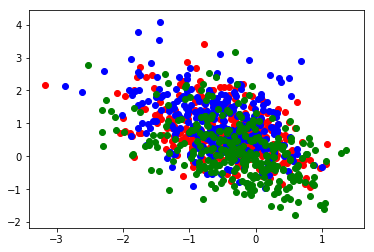

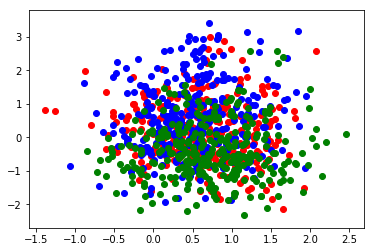

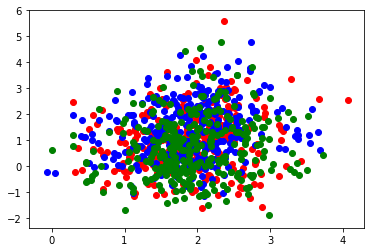

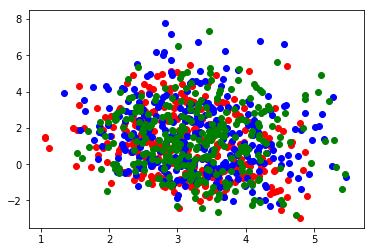

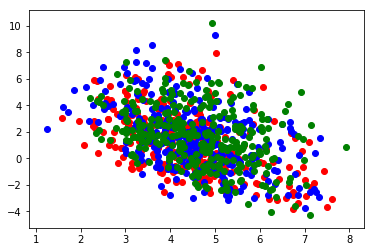

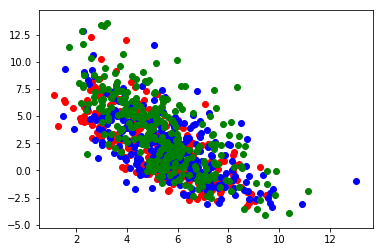

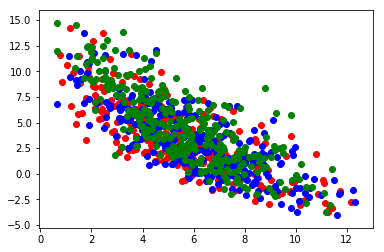

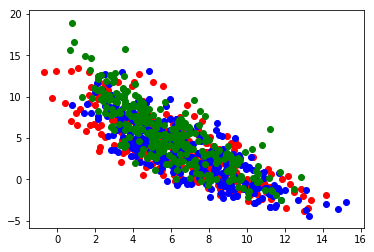

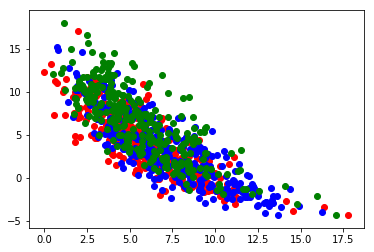

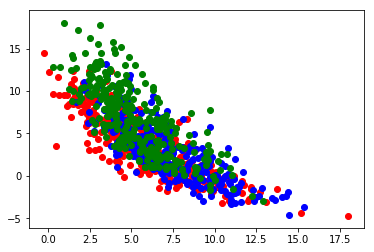

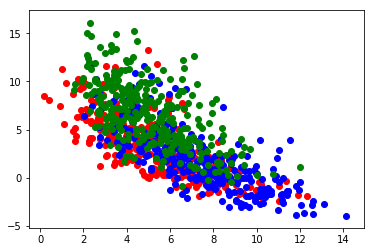

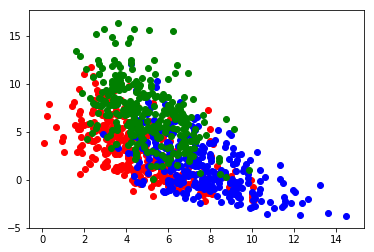

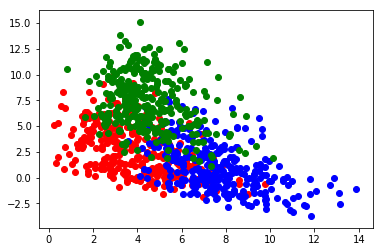

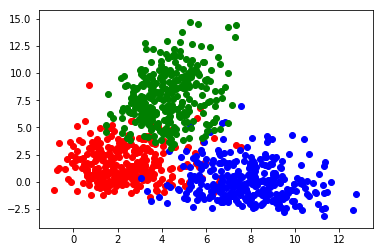

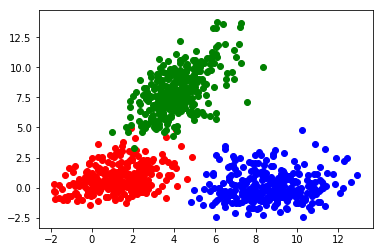

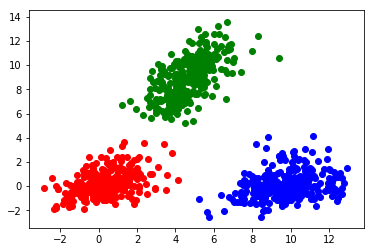

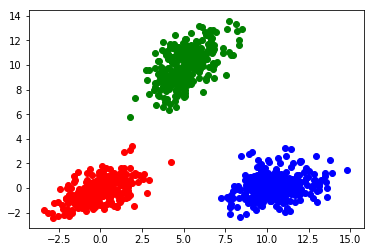

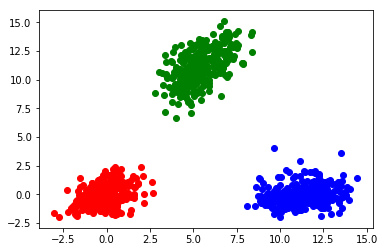

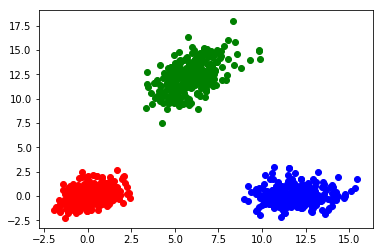

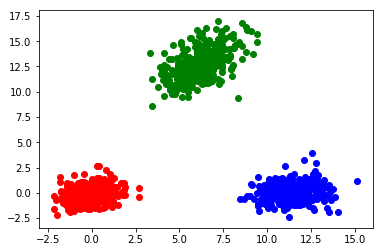

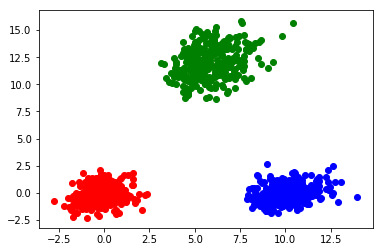

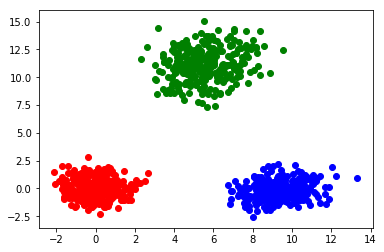

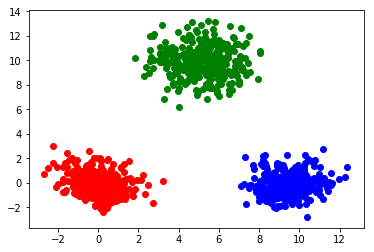

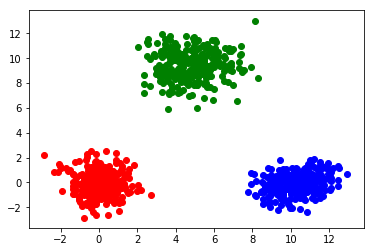

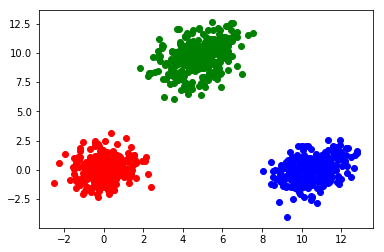

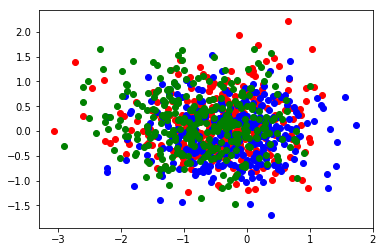

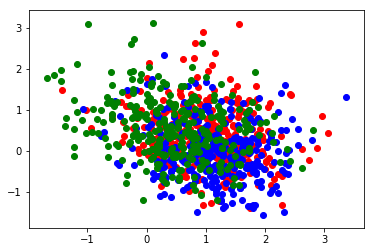

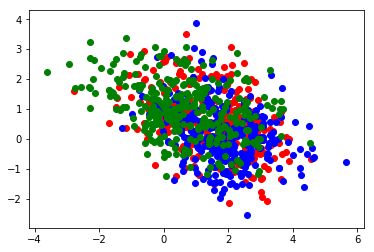

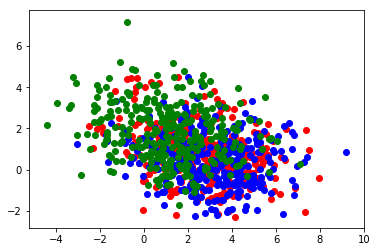

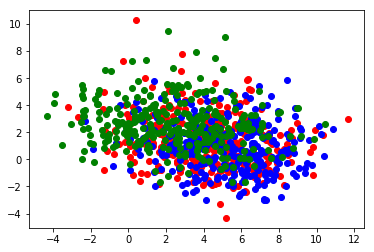

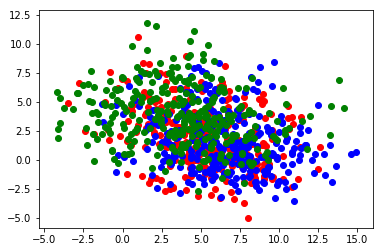

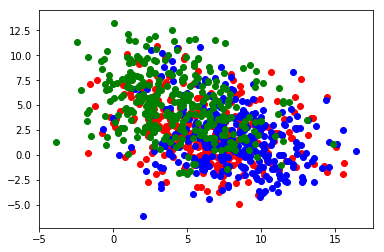

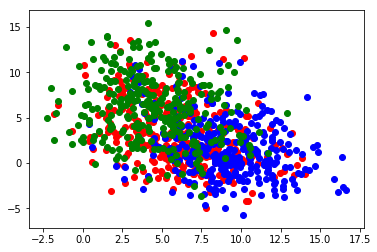

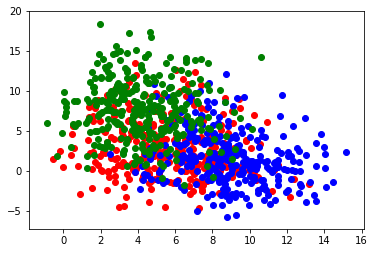

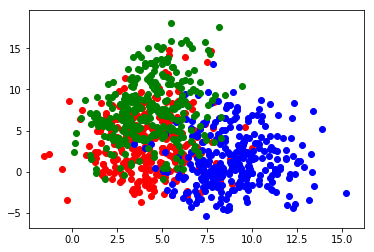

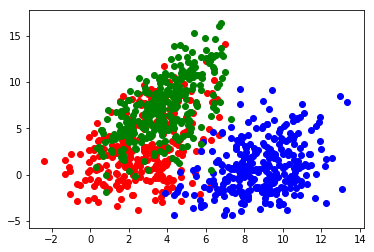

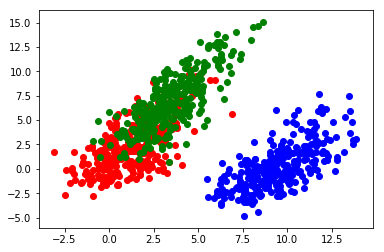

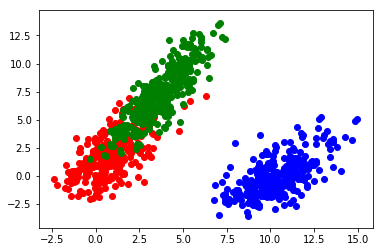

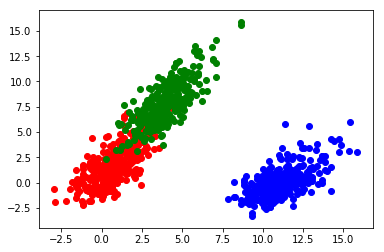

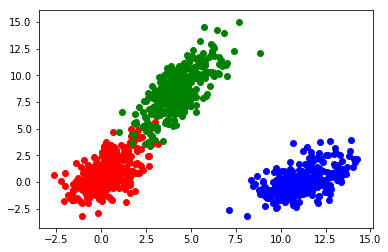

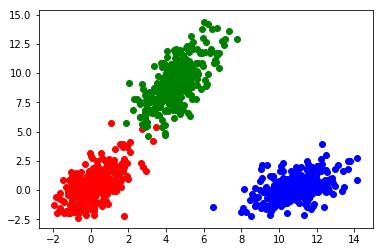

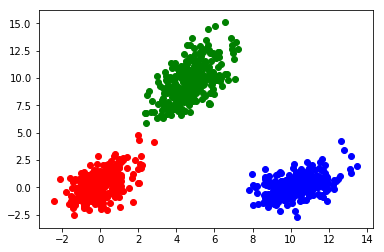

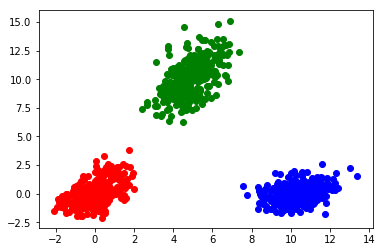

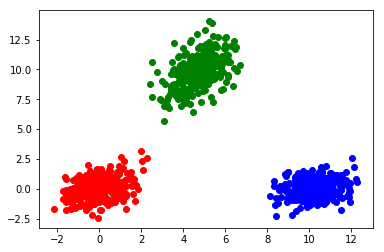

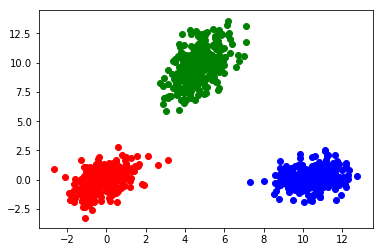

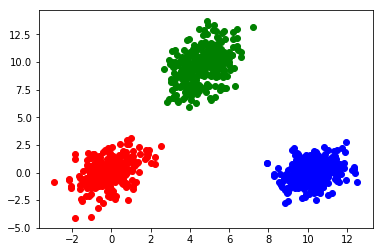

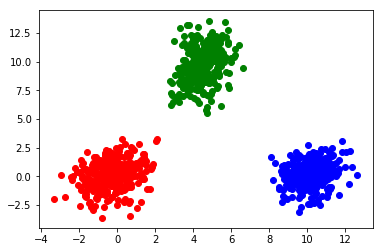

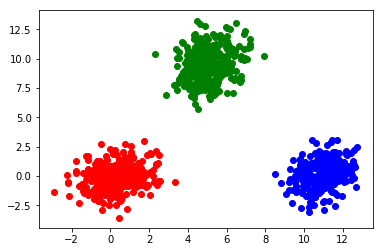

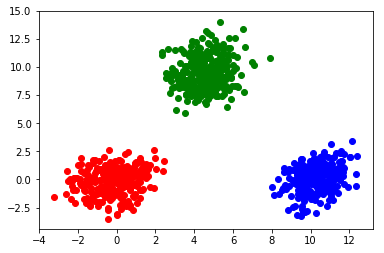

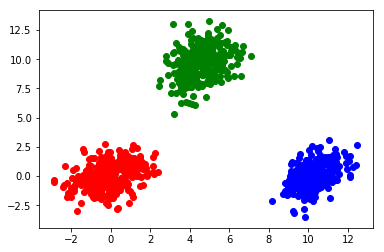

In [2]:
def train_gan():
  # Train Classifier
  
  # Initialize the variables (i.e. assign their default value)
  init = tf.global_variables_initializer()

  # Start training
  with tf.Session() as sess:

      # Run the initializer
      sess.run(init)
      
      # Initialize dataset for GAN train
      sess.run(iterator.initializer, feed_dict = {features: x_train, labels: y_train, batch_size: gan_batch_size, sample_size: 40000})
      
      #Train GAN 
      for i in range(50000):      
        # Sample random noise 
        batch = sess.run(next_batch)
        z = np.random.uniform(-1., 1., size=[gan_batch_size, noise_dim])
        #! Train Discriminator
        train_disc.run(feed_dict={train_x: batch[0], train_y:batch[1], gen_input: z})
        if i % 5 == 0:
          train_gen.run(feed_dict={train_x: batch[0], train_y:batch[1],  gen_input: z})
       
        # Take a snapshot
        if i % 2000 == 0:
          gl,dl = sess.run([gen_loss, disc_loss], feed_dict={train_x: batch[0], train_y:batch[1],  gen_input: z})
          print('Epoch %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))
          plot_gan_image('gan_out',str(i), sess)
   
      print('attacker gan train start!')
      #Train ATTACK GAN
      for i in range(50000):     
        # Sample random noise 
        z = np.random.uniform(-1., 1., size=[gan_batch_size, noise_dim])
        target_label = np.zeros([gan_batch_size, NUM_LABEL])
        for j in range(NUM_LABEL):
          target_label[j*100:(j+1)*100, j] = 1.
        
        #! Train Discriminator
        attack_train_disc.run(feed_dict={desired_label:target_label,  attack_gen_input: z})
        if i % 5 == 0:
          attack_train_gen.run(feed_dict={desired_label:target_label,  attack_gen_input: z})
       
        # Take a snapshot
        if i % 2000 == 0:
#           print('start output!')
          gl,dl = sess.run([attack_gen_loss, attack_disc_loss], feed_dict={desired_label:target_label,  attack_gen_input: z})
          print('Epoch %i: attack Generator Loss: %f, attack Discriminator Loss: %f' % (i, gl, dl))
          plot_attack_gan_image('attack_gan_out',str(i), sess)

        
if __name__ == '__main__':
  train_gan()